# Numeric Integration for DAEs
**Prepared by:** Prof. Alexander Dowling, Myia Dickens (mdicken2@nd.edu,2023)

The purpose of this notebook/class session is to provide the requisite background on numeric integration of DAEs. This helps appreciate the "direct transcription" approach for dynamic optimization used in `Pyomo.dae`.

In [1]:
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    # Do not need casadi for this notebook
    #!pip install casadi
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()


import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

## Single-Step Runge-Kutta Methods

* Chapter 9 in [Biegler (2010)](https://epubs.siam.org/doi/book/10.1137/1.9780898719383)
* Chapter 17 in [McClarren (2018)](https://www.sciencedirect.com/book/9780128122532/computational-nuclear-engineering-and-radiological-science-using-python)

### General Form: Index 0 DAE

Consider the ODE system:

$\begin{equation}
\dot{z} = f(t,z), \quad z(t_0) = z_0
\end{equation}$

where $z(t)$ are the differentail variables and $f(t,z)$ is a (nonlinear) continous function.

The general Runge-Kutta formula is:
$\begin{align}
z_{i+1} &= z_{i} + h_i \sum_{k=1}^{n_s} b_k f(t_i + c_k h_i, \hat{z}_k) \\
    \hat{z}_k &= z_i + h_i \sum_{j=1}^{n_{rk}} a_{k,j} f(t_i + c_j h_i, \hat{z}_j), \quad k=1,...,n_s 
\end{align}$

where
* $z_i$ are the differential variables at the **start** of **step** $i$ (time $t_i$)
* $z_{i+1}$ are the differential variables at the **end** of **step** $i$ (time $t_{i+1}$)
* $\hat{z}_k$ are differential variables for **intermediate stage** $k$
* $h_i$ is the size for step $i$ such that $t_{i+1} = t_i + h_i$
* $n_s$ is the number of stages
* $n_{rk}$ is the number of $f(\cdot)$ evaluations to calculate intermediate $k$
* $a_{k,j}$ are coefficients, together known as the *Runge-Kutta matrix*
* $b_k$ are cofficients, known as the *weights*
* $c_k$ are coefficients, know as the *nodes*

$h_i$ is selected based on error tolerances

The choice for $A$, $b$ and $c$ selects the specific method in the *Runge-Kutta family*. These coefficients are often specific in a [Butcher block](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#Explicit_Runge) (or Butcher tableau).

A Runge-Kutta method is called [**consistent**](https://en.wikiversity.org/wiki/Numerical_Analysis/stability_of_RK_methods) if:
$\begin{equation}
\sum_{k=1}^{n_s} b_k = 1 \quad \mathrm{and} \quad \sum_{j=1}^{n_s} a_{k,j} = c_k
\end{equation}$

### Explicit (Forward) Euler

Consider one of the simplest Runge-Kutta methods:

$$z_{i+1} = z_{i} + h_i~f(t_i, z_i)$$

What are $A$, $b$ and $c$ in the general formula?

$n_s = 1$. This is only a single stage. Thus we only need to determine $c_1$, $b_1$, and $n_{r1}$

Moreover, $\hat{z}_1 = z_i$ because $f(\cdot)$ is only evaluated at $t_i$ and $z_i$. This implies:
* $n_{r1} = 0$
* $c_1 = 0$
* $b_1 = 1$
* $A$ is empty because $n_{r1} = 0$

The implementation is very straightword (see below). We can calculate $z_{i+1}$ with a single line!

In [2]:
def create_steps(tstart,tend,dt):
    n = int(np.ceil((tend-tstart)/dt))
    return dt*np.ones(n)

def explicit_euler(f,h,z0):
    '''
    Arguments:
        f: function that returns rhs of ODE
        h: list of step sizes
        z0: initial conditions
        
    Returns:
        t: list of time steps. t[0] is 0.0 by default
        z: list of differential variable values
    '''
    
    # Number of timesteps
    nT = len(h) + 1
    
    t = np.zeros(nT)
    
    # Number of states
    nZ = len(z0)
    Z = np.zeros((nT,nZ))
    
    # Copy initial states
    Z[0,:] = z0
    
    for i in range(1,nT):
        
        i_ = i-1
        
        # Advance time
        t[i] = t[i_] + h[i_]
        
        # Implicit Euler formula
        Z[i,:] = Z[i_,:] + h[i_]*f(t[i_],Z[i_,:])
        
    return t, Z

### Implicit (Backward) Euler

Consider another simple Runge-Kutta method:

$$z_{i+1} = z_{i} + h_i~f(t_{i+1}, z_{i+1})$$

What are $A$, $b$ and $c$ to express using the general formula?

$n_s = 1$. Thus is only a single stage. Moreover, $\hat{z}_1 = z_{i+1}$ because $f(\cdot)$ is evaluated at $t_{i+1}$ and $z_{i+1}$. This implies:
* $b_1 = 1$
* $c_1 = 1$

Moreover, $z_{i+1} = z_{i} + h_i~f(t_{i+1}, z_{i+1})$ implies $\hat{z}_1 = z_i + h_i f(t_{i+1}, \hat{z}_1)$. Thus:
* $a_{1,1} = 1$

Notice that the formula for $z_{i+1}$ is implicit. We need to solve a (nonlinear) system of equations to calculate the step.

In [3]:
def implicit_euler(f,h,z0):
    '''
    Arguments:
        f: function that returns rhs of ODE
        h: list of step sizes
        z0: initial conditions
        
    Returns:
        t: list of time steps. t[0] is 0.0 by default
        z: list of differential variable values
    '''
    
    # Number of timesteps
    nT = len(h) + 1
    
    t = np.zeros(nT)
    
    # Number of states
    nZ = len(z0)
    Z = np.zeros((nT,nZ))
    
    # Copy initial states
    Z[0,:] = z0
    
    for i in range(1,nT):
        
        i_ = i-1
        
        # Advance time
        t[i] = t[i_] + h[i_]
        
        ## Implicit Runge-Kutta formula.
        ## Need to solve nonlinear system of equations.
        
        # Use Explicit Euler to calculate initial guess
        Z[i,:] = Z[i_,:] + h[i_]*f(t[i_],Z[i_,:])
        
        # Solve nonlinear equation
        implicit = lambda z : Z[i_,:] + h[i_]*f(t[i_],z) - z
        Z[i,:] = opt.fsolve(implicit, Z[i,:])
        
        
    return t, Z

## Key Differences

| Explicit Methods 	| Implicit Methods 	|
|:---:	|:---:	|
| + Easy to Program  	| + Requires converging system of nonlinear equations 	|
| - $h_i$ is limited by Stability 	| + Stability is independent of $h_i$ 	|

### Comparison

Let's test this on a simple problem:

$\begin{equation}
\dot{z}(t) = -\lambda z(t), \qquad z_0 = 1.
\end{equation}

The solution to this problem is 
\begin{equation}
z(t) = e^{-\lambda t}.
\end{equation}

For simplicity, let's numerically analyze $\lambda = 1$.

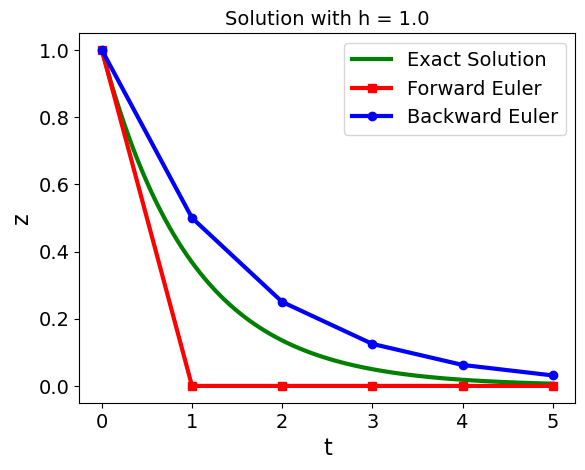

In [4]:
rhs = lambda t, z: -z
sln = lambda t: np.exp(-t)

dt = 1.0
h = create_steps(0.0,5.0,dt)

z0 = [1]

te, Ze = explicit_euler(rhs, h, z0)
ti, Zi = implicit_euler(rhs, h, z0)

plt.figure()

# Use 101 points for exact to make it smooth
texact = np.linspace(0.0,np.sum(h),101)

# Plot solutions
plt.plot(texact, sln(texact),color='green',label="Exact Solution")
plt.plot(te,Ze,color='red',marker='s',label='Forward Euler')
plt.plot(ti,Zi,color='blue',marker='o',label='Backward Euler')
plt.xlabel('t')
plt.ylabel('z')
plt.legend()
plt.title('Solution with h = '+ str(dt))
plt.show()

### Stability

Keeping $\lambda = 1$, are there any limits on step size?



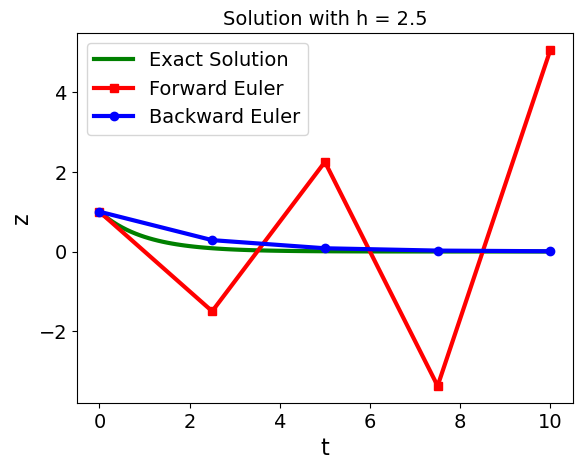

In [5]:
dt = 2.5
h = create_steps(0.0,10.0,dt)

z0 = [1]

te, Ze = explicit_euler(rhs, h, z0)
ti, Zi = implicit_euler(rhs, h, z0)

plt.figure()

# Use 101 points for exact to make it smooth
texact = np.linspace(0.0,np.sum(h),101)

# Plot solutions
plt.plot(texact, sln(texact),color='green',label="Exact Solution")
plt.plot(te,Ze,color='red',marker='s',label='Forward Euler')
plt.plot(ti,Zi,color='blue',marker='o',label='Backward Euler')
plt.xlabel('t')
plt.ylabel('z')
plt.legend()
plt.title('Solution with h = '+ str(dt))
plt.show()

**Key observation:** forward (explicit) Euler becomes unstable with large steps whereas backward (implicit) Euler is stable.

There is a good mathematical reason for this! See http://www.it.uu.se/edu/course/homepage/bridging/ht13/Stability_Analysis.pdf for details.

**Key results** (for this specific test problem):
* Explicit Euler requires step sizes with $h < 2/\lambda$.
* Implicit Euler is *unconditionally stable* provided $\lambda > 0$.
* Similar analysis and concepts extend to Runge-Kutta methods.

### Error Analysis

How does our choice in step size $h$ impact the error of these numerical techniques?



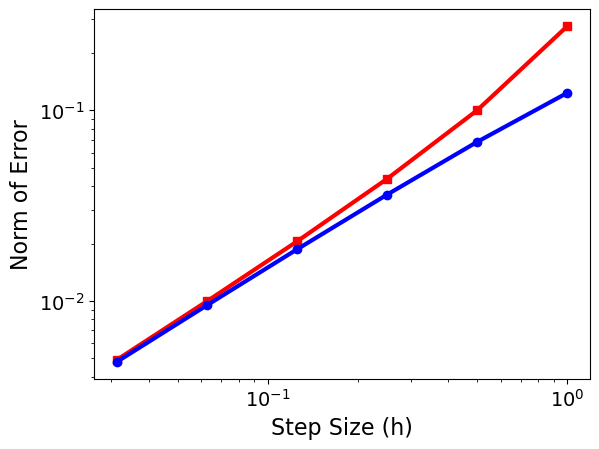

Slope for Forward Euler: 1.0220608473216777
Slope for Backward Euler: 0.9874086317220228


In [6]:
Delta_t = np.array([1.0,.5,.25,.125,.0625,.0625/2])
t_final = 2
error_forward = np.zeros(Delta_t.size)
error_backward = np.zeros(Delta_t.size)

for i in range(0,len(Delta_t)):
    
    # create steps
    h = create_steps(0.0,t_final,Delta_t[i])
    
    # solve
    t,ze = explicit_euler(rhs, h, z0)
    t,zi = implicit_euler(rhs, h, z0)
    zsln = np.exp(-t)
    
    n = len(t) - 1
    
    # Calculate error
    error_forward[i] = np.linalg.norm(ze[:,0] - zsln)/np.sqrt(n)
    error_backward[i] = np.linalg.norm(zi[:,0] - zsln)/np.sqrt(n)
    

plt.loglog(Delta_t,error_forward,'s-',color="red",label="Forward Euler")
plt.loglog(Delta_t,error_backward,'o-',color="blue",label="Backward Euler")

#slope = (np.log(error[-1]) - np.log(error[-2]))/(np.log(Delta_t[-1])- np.log(Delta_t[-2]))
#plt.title("Slope of Error is " + str(slope))
plt.xlabel("Step Size (h)")
plt.ylabel("Norm of Error")
plt.show()

# Calculate slope
calc_slope = lambda error: (np.log(error[-1]) - np.log(error[-2]))/(np.log(Delta_t[-1])- np.log(Delta_t[-2]))

print("Slope for Forward Euler: " + str(calc_slope(error_forward)))
print("Slope for Backward Euler: " + str(calc_slope(error_backward)))

Notice that the error indicates that this is a first-order method in $\Delta t$: when I decrease $\Delta t$ by a factor of 2, the error decreases by a factor of 2.  In this case we measured the error with a slightly different error norm:
$$\mathrm{Error} = \frac{1}{\sqrt{N}}\sqrt{\sum_{n=1}^{N} \left(y^n_\mathrm{approx} - y^n_\mathrm{exact}\right)^2},$$
where $N$ is the number of steps the ODE is solved over.

**Key Results**:
* Implicit and Explicit Euler have $O(h^2)$ local error and $O(h)$ global error.

## Extending Numeric Integration to Index-1 DAEs

Consider semi-explicit DAEs:
$$\begin{equation*}
\dot{z} = f(t,z,y), \quad g(z,y) = 0, \quad z(t_0) = z_0
\end{equation*}$$

Runge-Kutta methods are easy to extend.

$$\begin{align*}
z_{i+1} &= z_{i} + h_i \sum_{k=1}^{n_s} b_k f(t_i + c_k h_i, \hat{z}_k, \hat{y}_k) \\
    \hat{z}_k &= z_i + h_i \sum_{j=1}^{n_{rk}} a_{k,j} f(t_i + c_j h_i, \hat{z}_j, \hat{y}_j), \quad k=1,...,n_s \\
    0 &= g(\hat{z}_k, \hat{y}_k), \quad k=1,...,n_s
\end{align*}$$

The Backwards Euler is also another method to use to extend.

$$\begin{align*}
  z_{i+1} &= \sum_{j=1}^{n_s} \alpha_j z_{i-j+1} + \beta_0 hf(z_{i+1},y_{i+1})\\
  0 &= g(z_{i+1},y_{i+1})
\end{align*}$$

If using the Backwards Euler, the solution can be found using Newton's method and the Jacobian given by:

$$\begin{align*}
J(z_{i+1},y_{i+1}) &= 
\begin{bmatrix}
I - h\beta_0\frac{\partial f}{\partial z}^T
& h\beta_0\frac{\partial f}{\partial z}^T \\
\frac{\partial g}{\partial z}^T & \frac{\partial g}{\partial y}^T
\end{bmatrix}
\end{align*}$$

**Key Results**. If DAE is index 1, then similar stability and order properties as for ODE problems.

**Discussion:** Why are *implicit* RK methods always used for DAE systems?

### Solving Index-1 DAEs using Backwards Euler Method

Reference: **Pyomo - Optimization Modeling in Python** (Hart, 2010)

Consider the following optimal control problem


$\begin{align} \min \quad & x_3(t_f) \\
\mathrm{s.t.} \quad & \dot{x}_1 = x_2 \\
& \dot{x}_2 = -x_2 + u  \\
& \dot{x}_3 = x_1^2 + x_2^2 + 0.005 \cdot u^2 \\
& x_2 - 8 \cdot((t-0.5)^2+0.5 \leq 0 \\
& x_1(0) = 0, x_2(0) = 01, x_3(0) = 0, t_f = 1 
\end{align}$

*Discussion*: What variable is the problem attempting to minimize? What variable is being optimized? What are the types of equations are there?



In [7]:
### Begin Solution
# Minimizing variable: u
# Optimized varibale: x3
# Types of equations: 3 differential equations in the constraints and a path constraint, which is an inequality constraint restricting a varibale. 
# In this case, the variable being constricted in x2.
### End Solution

In [8]:
import pyomo.environ as pyo
import pyomo.dae as dae

In [9]:
def create_model_index1():

  # Create model
  m = pyo.ConcreteModel()

  # Declare time set
  m.tf = pyo.Param(initialize = 1) #final time
  m.t = dae.ContinuousSet(bounds=(0,m.tf))

  # Declare constraint and input variables
  m.u = pyo.Var(m.t, initialize = 0)
  m.x1 = pyo.Var(m.t)
  m.x2 = pyo.Var(m.t)
  m.x3 = pyo.Var(m.t)

  # Declare differential variables
  m.dx1 = dae.DerivativeVar(m.x1, wrt=m.t)
  m.dx2 = dae.DerivativeVar(m.x2, wrt=m.t)
  m.dx3 = dae.DerivativeVar(m.x3)

  # Declare differential equations
  def _x1dot(m,t):
    if t == m.t.first():
      return pyo.Constraint.Skip
    return m.dx1[t] == m.x2[t]
  m.x1dotcon = pyo.Constraint(m.t, rule=_x1dot)

  def _x2dot(m,t):
    if t == m.t.first():
      return pyo.Constraint.Skip
    return m.dx2[t] == -m.x2[t] + m.u[t]
  m.x2dotcon = pyo.Constraint(m.t, rule=_x2dot)

  def _x3dot(m,t):
    if t == m.t.first():
      return pyo.Constraint.Skip
    return m.dx3[t] == m.x1[t]**2+m.x2[t]**2+0.005*m.u[t]**2
  m.x3dotcon = pyo.Constraint(m.t, rule=_x3dot)

  # Declare inequality constraints
  def _con(m,t):
    return m.x2[t]-8*(t-0.5)**2+0.5 <= 0
  m.con = pyo.Constraint(m.t, rule = _con)

  # Declare the intial conditions
  def _init(m):
    yield m.x1[0] == 0
    yield m.x2[0] == -1
    yield m.x3[0] == 0
  m.init_conditions = pyo.ConstraintList(rule=_init)

  # Declare Objective function
  m.obj = pyo.Objective(expr = m.x3[m.tf])

  return m

# Solve model using Backwards Euler Method
def dae_index1_BackEuler(m):
  '''
    Arguments:
      m: DAE model of Index 1
    New Elements:
      nfe = number for finite elements - specifies the number of discretization points to be used
    Purpose:
      Solves DAE model using Backwards Euler method
  '''

  discretizer = pyo.TransformationFactory('dae.finite_difference')
  discretizer.apply_to(m, nfe=20, wrt=m.t, scheme = 'BACKWARD')

  solver = pyo.SolverFactory('ipopt')
  results = solver.solve(m, tee = True)

# Plot the results
def plotter(subplot, x, *y, **kwds):
  plt.subplot(subplot)
  for i,_y in enumerate(y):
    plt.plot(list(x), [pyo.value(_y[t]) for t in x], 'brgcmk' [i%6])
    if kwds.get('points',False):
      plt.plot(list(x), [pyo.value(_y[t]) for t in x], 'o')
  plt.title(kwds.get('title',''),fontsize = 16, fontweight='bold')
  plt.tick_params(direction="in",labelsize=15)
  plt.legend(tuple(_y.name for _y in y))
  plt.xlabel(x.name, fontsize = 16, fontweight='bold')


def plot_results(m):
  plotter(121, m.t, m.x1, m.x2, title = 'Differential Variables')
  plotter(122, m.t, m.u, title='Control Varibale', points=True)
  plt.show()

# Create model
model = create_model_index1()

In [10]:
# Solve DAEs
results = dae_index1_BackEuler(model)

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      363
Number of nonzeros in inequality constraint Jacobian.:       21
Number of nonzeros in Lagrangian Hessian.............:       60

Total number of variables............................:      143
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      123
Total number

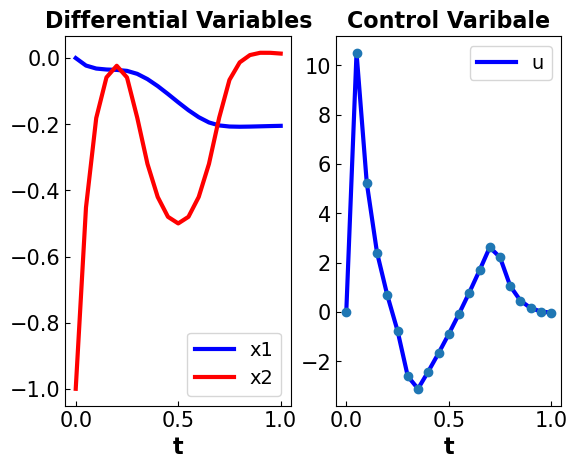

In [11]:
# Plot solution
plot_results(model)